# <font color=DeepSkyBlue >**Panel Data of Individual Wages** </font>

### ***by Xiaoxuan Ma***

## Agenda
* [<font color=DeepSkyBlue>**Overview**</font>](#1)
* [<font color=DeepSkyBlue>**Descriptive facts**</font>](#2)
* [<font color=DeepSkyBlue>**Distribution of log wage**</font>](#3)
* [<font color=DeepSkyBlue>**Examining and cleaning outlier**</font>](#4)
* [<font color=DeepSkyBlue>**Panel Data Models**</font>](#5)

## Overview<a name="1"></a>

### Panel data characteristics

1.Panel data provide information on individual behavior, both across individuals and over time – they have both **cross-sectional** and **time-series** dimensions.

2.Panel data include **N individuals** observed at **T regular time periods**.

3.Panel data can be balanced when all individuals are observed in all time periods.

### Data for this project

In [3]:
#install.packages("plm")
library(plm)
library(dplyr)
library(moments)

data('Wages', package = 'plm')
pd <- pdata.frame(Wages, index=595) #convert to a pdata.frame.
attach(pd)

In [4]:
head(pd, 10)

,exp,wks,bluecol,ind,south,smsa,married,sex,union,ed,black,lwage,id,time
1-1,3,32,no,0,yes,no,yes,male,no,9,no,5.56068,1,1
1-2,4,43,no,0,yes,no,yes,male,no,9,no,5.72031,1,2
1-3,5,40,no,0,yes,no,yes,male,no,9,no,5.99645,1,3
1-4,6,39,no,0,yes,no,yes,male,no,9,no,5.99645,1,4
1-5,7,42,no,1,yes,no,yes,male,no,9,no,6.06146,1,5
1-6,8,35,no,1,yes,no,yes,male,no,9,no,6.17379,1,6
1-7,9,32,no,1,yes,no,yes,male,no,9,no,6.24417,1,7
2-1,30,34,yes,0,no,no,yes,male,no,11,no,6.16331,2,1
2-2,31,27,yes,0,no,no,yes,male,no,11,no,6.21461,2,2
2-3,32,33,yes,1,no,no,yes,male,yes,11,no,6.26340,2,3


A panel of 595 individuals from 1976 to 1982, taken from the Panel Study of Income Dynamics (PSID).

The data are organized as a stacked time series/balanced panel.

total number of observations : 4165

observation : individuals

country : United States

Checking if there is any nan in the dataframe.

In [5]:
print(paste("number of missing values: ",sum(is.na(pd))))

[1] "number of missing values:  0"


### Topics overview

I use Jupyter Notebook to show the codes and results, and use PowerPoint to summarize and present the results.

Due to the limited time provided, I will focus on the follow questions:  
1) Highlight three descriptive facts from the data with supporting analysis and graphs.   
2) Pick a continuous variable of interest, what is the distribution of this variable?   
3) Continuing from above, how would you examine and clean outlier?  
5) Build a model from data, share with us the insights and results.  


Also, I'll briefly talk about my thoughts about some other questions.

## Descriptive facts from the data<a name="2"></a>

### 1. Means and Variations of variables 

 **There are four continuous variables:**   
 years of full-time work experience,   
 weeks worked,  
 years of education,  
 logarithm of wage.
   
 Let's use basic statistics to summary them.   

**Means**

In [6]:
pd_mean <- pd %>% summarise(mean(exp), mean(wks), mean(ed), mean(lwage))
pd_mean <- round(pd_mean,2)
pd_mean

mean(exp),mean(wks),mean(ed),mean(lwage)
19.85,46.81,12.85,6.68


**Overall variation: variation over time and individuals.**

In [7]:
pd_sd_overall <- pd %>% summarise(sd(exp), sd(wks), sd(ed), sd(lwage))
pd_sd_overall <- round(pd_sd_overall,2)
pd_sd_overall

sd(exp),sd(wks),sd(ed),sd(lwage)
10.97,5.13,2.79,0.46


**Between variation: variation between individuals.**


In [8]:
pd_sd_between <- pd %>% group_by(id) %>% 
                 summarise_at(vars(exp, wks, ed, lwage),mean) %>% 
                 summarise_at(vars( exp, wks, ed, lwage),sd)
pd_sd_between <- round(pd_sd_between,2)
pd_sd_between

exp,wks,ed,lwage
10.79,3.28,2.79,0.39


**Within variation: variation within individuals over time.**

In [9]:
pd_sd_within <- (pd_sd_overall**2 - pd_sd_between**2)**0.5
pd_sd_within <- round(pd_sd_within,2)
pd_sd_within

sd(exp),sd(wks),sd(ed),sd(lwage)
1.98,3.94,0,0.24


### 2. Average log wages of males and females over time.

In [11]:
male_wage_mean <- pd %>% group_by(time) %>% filter(sex == 'male') %>% summarise_at(vars(lwage),mean) 
male_wage_mean

time,lwage
1,6.423298
2,6.515570
3,6.655162
4,6.752830
5,6.842012
6,6.915456
7,7.004088


In [12]:
female_wage_mean <- pd %>% group_by(time) %>% filter(sex == 'female') %>% summarise_at(vars(lwage),mean) 
female_wage_mean

time,lwage
1,5.995927
2,6.068366
3,6.136134
4,6.248850
5,6.348618
6,6.458892
7,6.530366


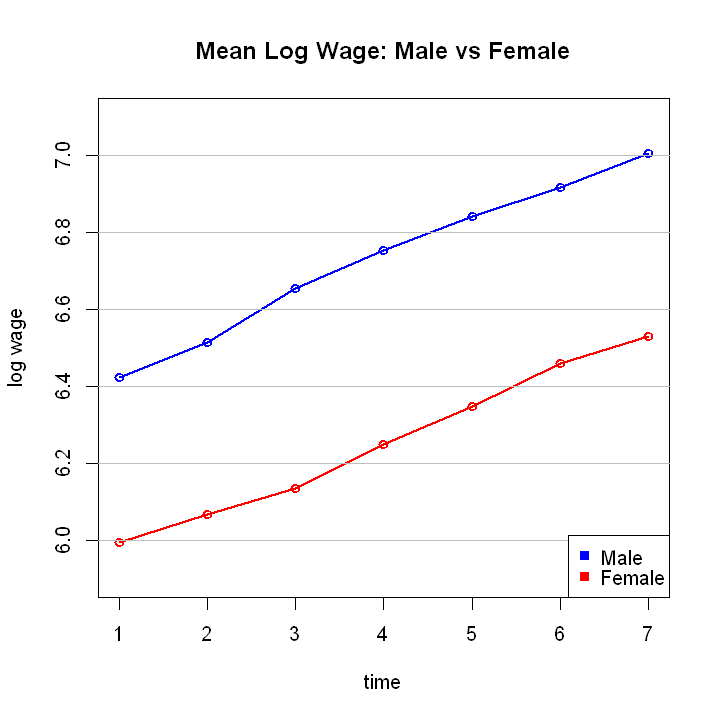

In [40]:
options(repr.plot.width=6, repr.plot.height=6)
plot(male_wage_mean$lwage,
     type = "o",col = 'blue',lwd=2, 
     xlab = "time", ylab = "log wage",ylim=c(5.9,7.1),
     main = 'Mean Log Wage: Male vs Female')
lines(female_wage_mean, type = "o", col = 'red',lwd=2)
grid(nx=NA,ny=NULL,lty=1,lwd=1,col=" gray")
legend("bottomright",pch=c(15,15),legend=c('Male','Female'),col=c('blue','red'))

### 3. Samples' distribution characteristics

Now, I use categorical variables to discover samples' distribution characteristics. Taking blue collar, sex, black at time 7 as an example.

In [15]:
t7 <- pd[which(time == 7),]

In [17]:
summary(t7)

      exp             wks        bluecol        ind        south      smsa    
 Min.   : 7.00   Min.   : 5.00   no :290   Min.   :0.000   no :421   no :213  
 1st Qu.:13.00   1st Qu.:46.00   yes:305   1st Qu.:0.000   yes:174   yes:382  
 Median :21.00   Median :48.00             Median :0.000                      
 Mean   :22.85   Mean   :46.45             Mean   :0.405                      
 3rd Qu.:32.00   3rd Qu.:49.00             3rd Qu.:1.000                      
 Max.   :51.00   Max.   :52.00             Max.   :1.000                      
                                                                              
 married       sex      union           ed        black         lwage      
 no :116   male  :528   no :377   Min.   : 4.00   no :552   Min.   :5.677  
 yes:479   female: 67   yes:218   1st Qu.:12.00   yes: 43   1st Qu.:6.685  
                                  Median :12.00             Median :6.985  
                                  Mean   :12.85             Mean

In [20]:
t7_blue <- t7[which(t7$bluecol == 'yes'),]
table(t7_blue$sex)


  male female 
   276     29 

In [21]:
t7_blue_male <- t7_blue[which(t7_blue$sex == 'male'),]
table(t7_blue_male$black)


 no yes 
261  15 

In [23]:
t7_blue_female <- t7_blue[which(t7_blue$sex == 'female'),]
table(t7_blue_female$black)


 no yes 
 16  13 

In [24]:
t7_nonblue <- t7[which(t7$bluecol == 'no'),]
table(t7_nonblue$sex)


  male female 
   252     38 

In [25]:
t7_nonblue_male <- t7_nonblue[which(t7_nonblue$sex == 'male'),]
table(t7_nonblue_male$black)


 no yes 
239  13 

In [26]:
t7_nonblue_female <- t7_nonblue[which(t7_nonblue$sex == 'female'),]
table(t7_nonblue_female$black)


 no yes 
 36   2 

## Distribution of log wage<a name="3"></a>

Taking the log wage at time 7 as an example, let's try to find it's distribution.

In [27]:
lwage7 <- t7$lwage

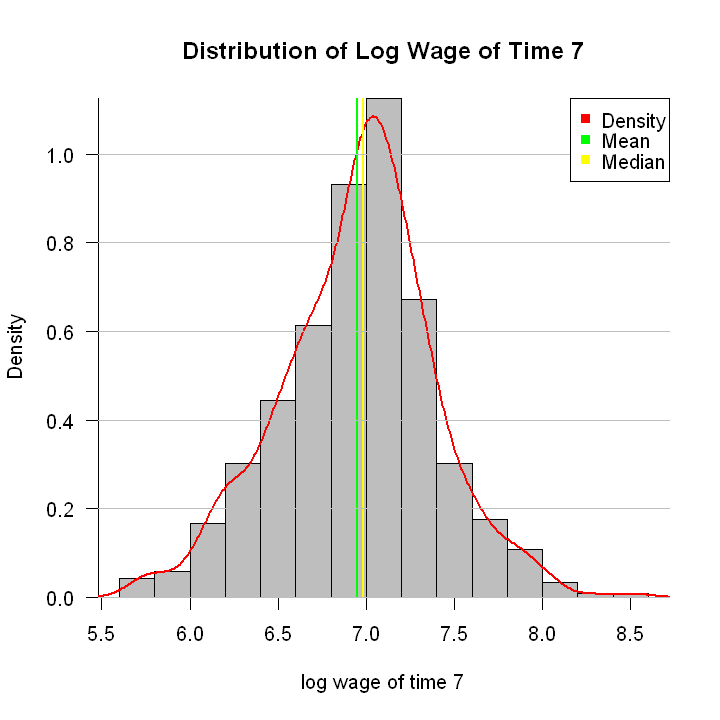

In [41]:
options(repr.plot.width=6, repr.plot.height=6)
par(yaxs='i',las=1)
hist(lwage7,
     freq=FALSE,
     col='grey',border='black',
     xlab='log wage of time 7',
     main='Distribution of Log Wage of Time 7')
box(bty='l')
lines(density(lwage7,na.rm=T),col='red',lwd=2)
abline(v=mean(lwage7), col='green' ,lwd=2)
abline(v=median(lwage7), col='yellow' ,lwd=2)
grid(nx=NA,ny=NULL,lty=1,lwd=1,col=" gray")
legend("topright",pch=c(15,15,15),legend=c('Density','Mean','Median'),col=c('red','green','yellow'))

In [29]:
skewness(lwage7)

[1] -0.1140005

In [30]:
kurtosis(lwage7)

[1] 3.393651

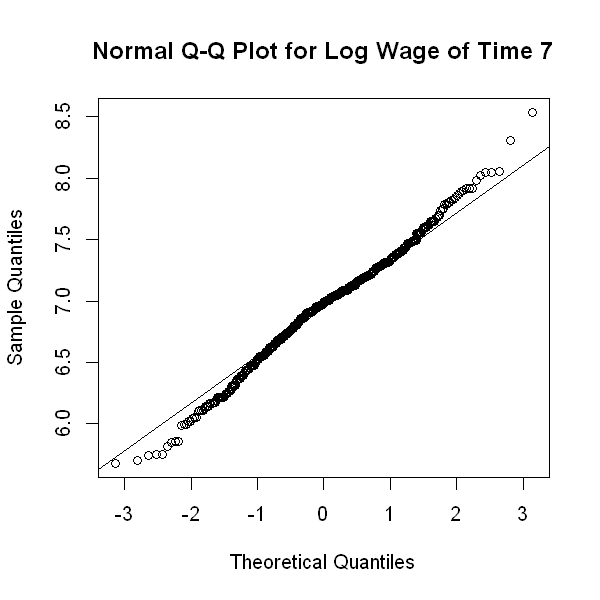

In [42]:
options(repr.plot.width=5, repr.plot.height=5)
qqnorm(lwage7, main = 'Normal Q-Q Plot for Log Wage of Time 7')
qqline(lwage7)

In [35]:
nortest <- shapiro.test(lwage7)
nortest


	Shapiro-Wilk normality test

data:  lwage7
W = 0.99239, p-value = 0.003932


## Examining and cleaning outlier<a name="4"></a>

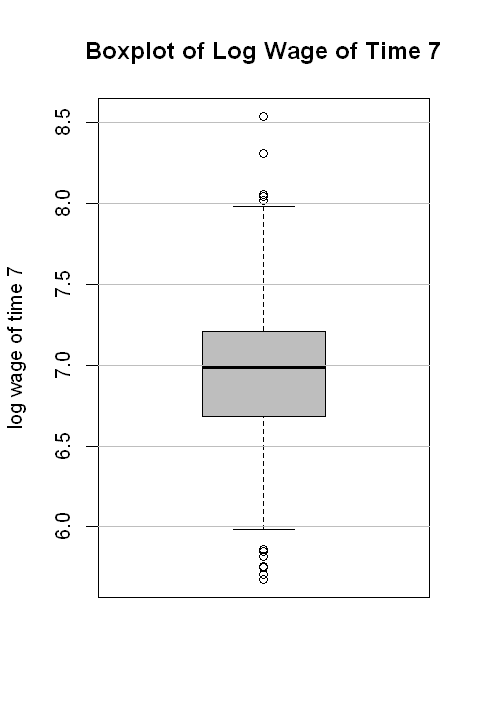

In [38]:
options(repr.plot.width=4, repr.plot.height=6)
boxplot(lwage7,col="grey",border="black",
        ylab='log wage of time 7',
        main='Boxplot of Log Wage of Time 7')
grid(nx=NA,ny=NULL,lty=1,lwd=1,col=" gray")

In [43]:
outliers <- boxplot.stats(lwage7)$out
print(paste("number of outliers: ",length(outliers)))

[1] "number of outliers:  15"


In [44]:
m_lwage7 <- lwage7[! lwage7 %in% outliers]
print(paste("number of samples after cleaning outliers: ",length(m_lwage7)))

[1] "number of samples after cleaning outliers:  580"


## Panel Data Models<a name="5"></a>

The type of categorical variables is factor.

In [46]:
mpd <- pd
mpd$sex <- factor(mpd$sex,labels=c(0,1))
mpd$married <- factor(mpd$married,labels=c(0,1))
mpd$black <- factor(mpd$black,labels=c(0,1))
detach(pd)
attach(mpd)

In [47]:
pooling <- plm(lwage ~ exp + wks + ed + sex + married + black, data=mpd, model= "pooling")
summary(pooling)

Pooling Model

Call:
plm(formula = lwage ~ exp + wks + ed + sex + married + black, 
    data = mpd, model = "pooling")

Balanced Panel: n=595, T=7, N=4165

Residuals :
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-2.2034348 -0.2376862  0.0033105  0.2524530  1.9345178 

Coefficients :
               Estimate  Std. Error  t-value  Pr(>|t|)    
(Intercept)  5.30448293  0.06570553  80.7312 < 2.2e-16 ***
exp          0.01182958  0.00054972  21.5191 < 2.2e-16 ***
wks          0.00405787  0.00113382   3.5790 0.0003489 ***
ed           0.07374622  0.00214177  34.4323 < 2.2e-16 ***
sex1        -0.34976966  0.02662526 -13.1368 < 2.2e-16 ***
married1     0.06150482  0.02186638   2.8128 0.0049349 ** 
black1      -0.15159601  0.02316837  -6.5432 6.751e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Total Sum of Squares:    886.9
Residual Sum of Squares: 580.16
R-Squared:      0.34586
Adj. R-Squared: 0.34492
F-statistic: 366.411 on 6 and 4158 DF, p-value: < 2.2

In [52]:
between <- plm(lwage ~ exp + wks + ed + sex + married + black, data=mpd, model= "between")
summary(between)

Oneway (individual) effect Between Model

Call:
plm(formula = lwage ~ exp + wks + ed + sex + married + black, 
    data = mpd, model = "between")

Balanced Panel: n=595, T=7, N=4165
Observations used in estimation: 595

Residuals :
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-0.949431 -0.194872  0.031572  0.218650  0.818082 

Coefficients :
              Estimate Std. Error t-value  Pr(>|t|)    
(Intercept)  5.1686396  0.1981128 26.0894 < 2.2e-16 ***
exp          0.0085564  0.0011917  7.1797 2.119e-12 ***
wks          0.0078176  0.0037787  2.0688  0.038997 *  
ed           0.0712038  0.0045413 15.6793 < 2.2e-16 ***
sex1        -0.3015372  0.0603729 -4.9946 7.784e-07 ***
married1     0.1242968  0.0525362  2.3659  0.018308 *  
black1      -0.1389058  0.0491550 -2.8259  0.004875 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Total Sum of Squares:    92.322
Residual Sum of Squares: 52.576
R-Squared:      0.43051
Adj. R-Squared: 0.4247
F-statistic: 74.0853 on

In [50]:
random <- plm(lwage ~ exp + wks + ed + sex + married + black, data=mpd, model= "random")
summary(random)

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = lwage ~ exp + wks + ed + sex + married + black, 
    data = mpd, model = "random")

Balanced Panel: n=595, T=7, N=4165

Effects:
                  var std.dev share
idiosyncratic 0.02356 0.15349 0.215
individual    0.08605 0.29334 0.785
theta:  0.806  

Residuals :
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-2.0459196 -0.1149687  0.0021092  0.1184320  2.0643465 

Coefficients :
               Estimate  Std. Error t-value  Pr(>|t|)    
(Intercept)  4.29832874  0.09299567 46.2207 < 2.2e-16 ***
exp          0.05235392  0.00107787 48.5716 < 2.2e-16 ***
wks          0.00151232  0.00076914  1.9662 0.0493366 *  
ed           0.10749796  0.00579063 18.5641 < 2.2e-16 ***
sex1        -0.32979262  0.05512963 -5.9821 2.388e-09 ***
married1    -0.07301560  0.02313775 -3.1557 0.0016126 ** 
black1      -0.22763295  0.06302307 -3.6119 0.0003076 ***
---
Signif. codes:  0 '***' 0.001 '**' 

In [54]:
phtest(random, between)


	Hausman Test

data:  lwage ~ exp + wks + ed + sex + married + black
chisq = 8945.9, df = 6, p-value < 2.2e-16
alternative hypothesis: one model is inconsistent


***Thank you for reading!***